<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/REFLECTION_EQUIVARIANT_QUANTUM_NEURAL_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## REFLECTION EQUIVARIANT QUANTUM NEURAL NETWORK

In [1]:
%%capture
pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

For now, it's necessary to define the Equivariant Amplitude Embedding, which consists of a zig-zag way to embed the classical data x of length $2^n$ into the quantum state of $n$ qubits.

[tensor(-0.27953396, requires_grad=True), tensor(0.31181619, requires_grad=True), tensor(-0.16510834, requires_grad=True), tensor(0.04349554, requires_grad=True), tensor(0.02731852, requires_grad=True)]


(<Figure size 3600x600 with 1 Axes>, <Axes: >)

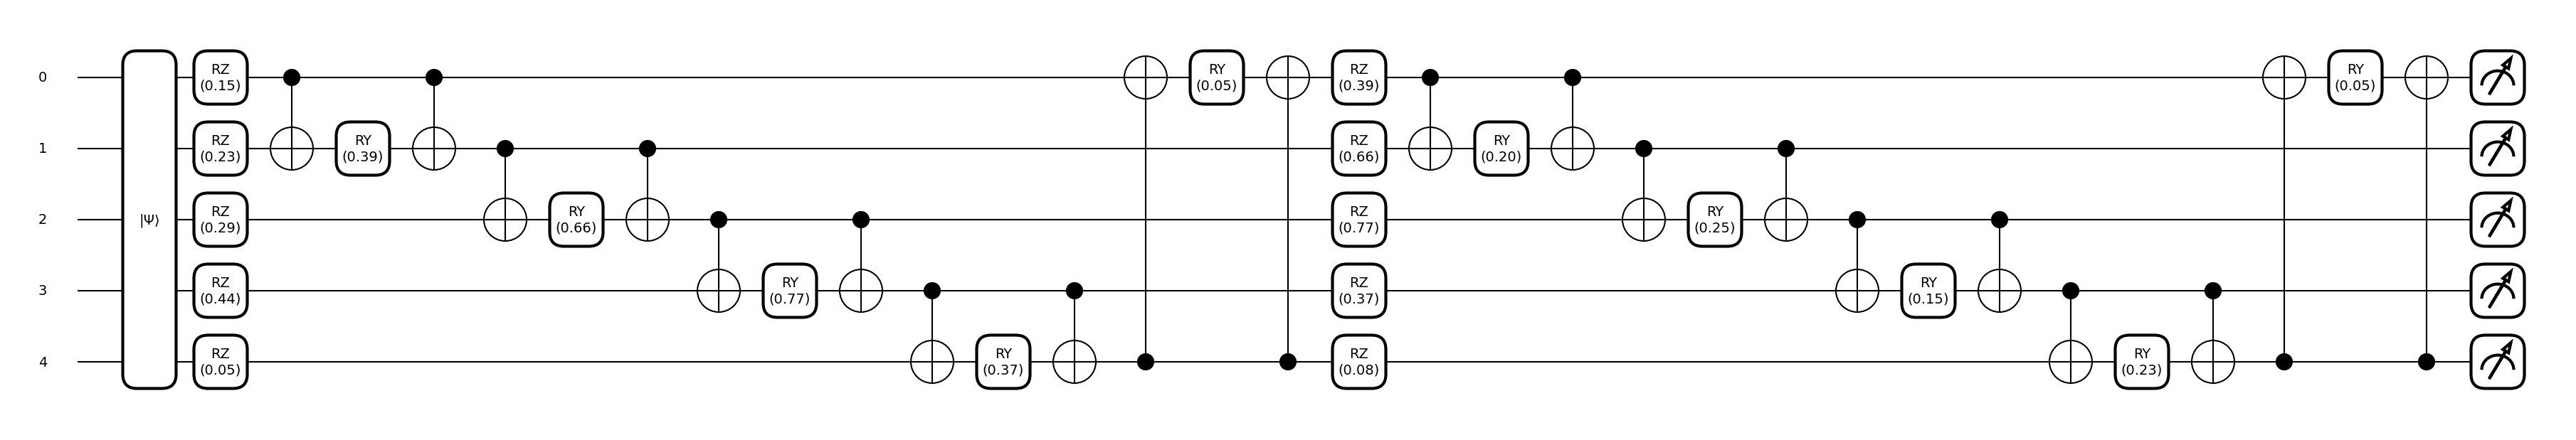

In [113]:
n = 5
L = 2
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def REQNN(x, params, qubits, n_layers=1, pad_with = False):
    """
    This EQNN function has been generalized to construct the architecture of a QNN
    equivariant under reflections with any number of qubits and layers.

    It performs the amplitude embedding of classical data x of length 2**n
    into a quantum state of n qubits. After that, a series of RZ and RY gates with
    trainable parameters is applied per L layers over all the qubits.
    In the end, we measure all the qubits with respect to the PauliZ observable.

    Args:
        x (array): Classical input data of length 2**n.
        params (array): Trainable parameters for the quantum gates.
        qubits (range): List of qubits to use.
        n_layers (int): Number of layers in the quantum network.

    Returns:
        list: Expectation values with respect to the PauliZ observable for each qubit.
    """

    # Amplitude Embedding
    qml.AmplitudeEmbedding(x, wires=range(len(qubits)), pad_with = pad_with, normalize=True)

    ## TRAINABLE BLOCK
    for L in range(n_layers):
        # Trainable rotations RZ
        for i in range(n):
            qml.RZ(params[(L-1)*n + i], wires=qubits[i])

        # Applying CNOT and RY gates
        for i in range(len(qubits) - 1):
            qml.CNOT(wires=[qubits[i], qubits[i+1]])
            qml.RY(params[L*n + i], wires=qubits[i+1])
            qml.CNOT(wires=[qubits[i], qubits[i+1]])

        # Applying CNOT and RY gates at the ends
        qml.CNOT(wires=[qubits[-1], qubits[0]])
        qml.RY(params[-1], wires=qubits[0])
        qml.CNOT(wires=[qubits[-1], qubits[0]])

    # Measurement of all qubits with respect to the Z observable
    return [qml.expval(qml.PauliZ(i)) for i in range(len(qubits))]

x = np.random.rand(2**n-1)
params = np.random.rand((n+1) * L)
qubits = range(n)

print(REQNN(x, params, qubits, L))
qml.draw_mpl(REQNN, decimals=2)(x, params, qubits, L, True)

## qml.state()
en el caso de wires = 2
regresa de la siguiente forma

$$|00⟩ + |01⟩ + |10⟩ + |11⟩$$

en general,
$$ |0⟩ + |1⟩ + |2⟩ + |3⟩ + ... $$

donde estos estados enteros deben ser traducidos a su forma binaria.

Pennylane considera los primeros qubits como los ultimos, por ejemplo si wires=3, entonces se aplican las compuertas al estados de la siguiente forma
$$|q_0, q_1, q_2 ⟩$$


## source code AmplitudeEmbedding

In [29]:
def amplitud_emb(features, wires, pad_with, normalize):
        """Validate and pre-process inputs as follows:

        * If features is batched, the processing that follows is applied to each feature set in the batch.
        * Check that the features tensor is one-dimensional.
        * If pad_with is None, check that the last dimension of the features tensor
          has length :math:`2^n` where :math:`n` is the number of qubits. Else check that the
          last dimension of the features tensor is not larger than :math:`2^n` and pad features
          with value if necessary.
        * If normalize is false, check that last dimension of features is normalised to one. Else, normalise the
          features tensor.
        """
        shape = qml.math.shape(features)

        # check shape
        if len(shape) not in (1, 2):
            raise ValueError(
                f"Features must be a one-dimensional tensor, or two-dimensional with batching; got shape {shape}."
            )

        n_features = shape[-1]
        dim = 2 ** len(wires)
        if pad_with is None and n_features != dim:
            raise ValueError(
                f"Features must be of length {dim}; got length {n_features}. "
                f"Use the 'pad_with' argument for automated padding."
            )

        if pad_with is not None:
            if n_features > dim:
                raise ValueError(
                    f"Features must be of length {dim} or "
                    f"smaller to be padded; got length {n_features}."
                )

            # pad
            if n_features < dim:
                padding = [pad_with] * (dim - n_features)
                if len(shape) > 1:
                    padding = [padding] * shape[0]
                padding = qml.math.convert_like(padding, features)
                features = qml.math.hstack([features, padding])

        # normalize
        norm = qml.math.sum(qml.math.abs(features) ** 2, axis=-1)

        if qml.math.is_abstract(norm):
            if normalize or pad_with:
                features = features / qml.math.reshape(qml.math.sqrt(norm), (*shape[:-1], 1))

        elif not qml.math.allclose(norm, 1.0):
            if normalize or pad_with:
                features = features / qml.math.reshape(qml.math.sqrt(norm), (*shape[:-1], 1))
            else:
                raise ValueError(
                    f"Features must be a vector of norm 1.0; got norm {norm}. "
                    "Use 'normalize=True' to automatically normalize."
                )

        return features

In [33]:
amplitud_emb([0.5, 0.33, 0.25, 0.7592], wires = range(), pad_with = False, normalize = True)

array([0.50055476, 0.33036614, 0.25027738, 0.76004235, 0.        ,
       0.        , 0.        , 0.        ])